In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import json
import pprint
from scipy.optimize import least_squares
import os
import pandas as pd
from astropy.cosmology import Planck15
import astropy.units as u

seed = 3

# Laod GWTC Snapshot & PE Samples

In [2]:
json_path = "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json"

# Load JSON data
with open(json_path, 'r') as f:
    data = json.load(f)

print(pprint.pprint(data['events']['GW150914-v3'].keys()))

# Extract mass_1_source values from all events
events = data["events"]
Catalog, far, rhoobs = [], [], []
Name = []

for event_name, event_data in events.items():

    Name.append(event_data['commonName'])

    Catalog.append(event_data.get("catalog.shortName"))
    far.append(event_data.get("far"))
    rhoobs.append(event_data.get("network_matched_filter_snr"))

# Convert to NumPy array
Catalog = np.array(Catalog, dtype=str)
far = np.array(far, dtype=float)
rhoobs = np.array(rhoobs, dtype=float)
Name = np.array(Name, dtype=str)

# Selection Cut
far_threshold = 1.
snr_threshold = 10.
mask = []
for i in range(len(Catalog)):
    if Catalog[i] == 'GWTC-3-confident':
        if far[i]<far_threshold:
            mask.append(True)
        else:
            mask.append(False)
    elif Catalog[i] == 'GWTC-2.1-confident' or Catalog[i] == 'GWTC-1-confident':
        if rhoobs[i]>snr_threshold:
            mask.append(True)
        else:
            mask.append(False)
    else:
        mask.append(False)
    
mask = np.array(mask)
Catalog, far, rhoobs, Name = Catalog[mask], far[mask], rhoobs[mask], Name[mask]

print('Catalog Size:', len(Catalog))
print('Is there any None:', np.where(far==None), np.where(rhoobs==None))

dict_keys(['commonName', 'version', 'catalog.shortName', 'GPS', 'reference', 'jsonurl', 'mass_1_source', 'mass_1_source_lower', 'mass_1_source_upper', 'mass_1_source_unit', 'mass_2_source', 'mass_2_source_lower', 'mass_2_source_upper', 'mass_2_source_unit', 'network_matched_filter_snr', 'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper', 'network_matched_filter_snr_unit', 'luminosity_distance', 'luminosity_distance_lower', 'luminosity_distance_upper', 'luminosity_distance_unit', 'chi_eff', 'chi_eff_lower', 'chi_eff_upper', 'chi_eff_unit', 'total_mass_source', 'total_mass_source_lower', 'total_mass_source_upper', 'total_mass_source_unit', 'chirp_mass_source', 'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass_source_unit', 'chirp_mass', 'chirp_mass_lower', 'chirp_mass_upper', 'chirp_mass_unit', 'redshift', 'redshift_lower', 'redshift_upper', 'redshift_unit', 'far', 'far_lower', 'far_upper', 'far_unit', 'p_astro', 'p_astro_lower', 'p_astro_upper', 'p_as

In [3]:
# Define directories and file suffix
directories = ["/mnt/home/ccalvk/ceph/GWTC-2.1/", "/mnt/home/ccalvk/ceph/GWTC-3/"]
suffix = "_PEDataRelease_mixed_nocosmo.h5"

# Ensure Name is a string-type numpy array
Name = Name.astype(str)

all_dfs = []
Name1 = []
rhoobs1 = []

for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith(suffix):
            for name in Name:
                # Match with prefix from either GWTC-2.1 or GWTC-3
                expected_prefix = f"IGWN-GWTC2p1-v2-{name}" if "GWTC-2.1" in directory else f"IGWN-GWTC3p0-v2-{name}"
                if filename.startswith(expected_prefix):
                    Name1.append(name)
                    rhoobs1.append(rhoobs[np.argwhere(Name==name)])
                    filepath = os.path.join(directory, filename)
                    with h5py.File(filepath, 'r') as f:
                        samplers = list(f.keys())
                        if len(samplers) < 2:
                            print(f"Not enough samplers in {filename}, skipping.")
                            continue

                        sampler = samplers[1]
                        dataset_path = f"{sampler}/posterior_samples"

                        if dataset_path in f:
                            data = f[dataset_path][()]  # Structured array
                            df = pd.DataFrame(data)
                            df["event"] = name  # Use event name from Name array
                            all_dfs.append(df)
                        else:
                            print(f"{dataset_path} not found in {filename}, skipping.")
                    break  # Found match, move to next file

print('Events missing in the PE directory:', np.abs(len(Catalog)-len(all_dfs)))
Name1 = np.array(Name1, dtype=str)
rhoobs1 = np.array(rhoobs1, dtype=float).flatten()

Events missing in the PE directory: 1


Weird, but will investigate later.

In [4]:
print('Catalog Size Now:', len(all_dfs))

Catalog Size Now: 61


Read only the parameters needed.

In [5]:
all_dfs[0].keys()

Index(['symmetric_mass_ratio', 'spin_1y', 'spin_2x', 'phi_2',
       'total_mass_source', 'mass_ratio', 'cos_tilt_2', 'spin_2z', 'chi_eff',
       'phi_12', 'chirp_mass', 'peak_luminosity', 'tilt_2', 'spin_1z',
       'mass_2_source', 'theta_jn', 'phi_jl', 'geocent_time', 'log_likelihood',
       'chi_p', 'mass_1_source', 'inverted_mass_ratio', 'spin_2y',
       'total_mass', 'phi_1', 'tilt_1', 'cos_tilt_1', 'radiated_energy',
       'chirp_mass_source', 'a_2', 'phase', 'dec', 'mass_1', 'spin_1x',
       'cos_iota', 'final_mass', 'luminosity_distance', 'ra', 'cos_theta_jn',
       'comoving_distance', 'a_1', 'iota', 'psi', 'final_mass_source',
       'final_spin', 'mass_2', 'redshift', 'tilt_1_infinity_only_prec_avg',
       'tilt_2_infinity_only_prec_avg', 'chi_p_2spin',
       'spin_1z_infinity_only_prec_avg', 'spin_2z_infinity_only_prec_avg',
       'chi_eff_infinity_only_prec_avg', 'chi_p_infinity_only_prec_avg',
       'beta', 'psi_J', 'cos_tilt_1_infinity_only_prec_avg',
       '

# Load Selection PE Samples

In [6]:
def load_selection_pe(file):
    with h5py.File(file, 'r') as f:

        # Load dataset into DataFrame
        info = f['info']
        T_yr = np.array(info["analysis_time_yr"])
        N_selection = np.array(info["total_injections"])
        
        # Load dataset into DataFrame
        injections = f['injections']
        df = pd.DataFrame({key: injections[key][()] for key in injections.keys()})

        # Load 2D NumPy arrays as a dictionary
        injections_pe = f['injections-pe']
        arrays = {
            key: injections_pe[key][()]
            for key in injections_pe.keys()
        }

    return T_yr, N_selection, df, arrays

################################################################################################################

file = "/mnt/home/sroy1/ceph/bumpcosmologygwtc3_Mc/data/Selection_Samples_With_Mock_PE.h5"
T_yr, N_selection, df, df_pe = load_selection_pe(file)

In [7]:
m1_sel = np.array(df_pe["Source_Frame_m1"])
m2_sel = np.array(df_pe["Source_Frame_m2"])
z_sel = np.array(df_pe["Redshift"])

Mc_sel = (m1_sel*m2_sel)**0.6/(m1_sel+m2_sel)**0.2

In [8]:
m1_sel_true = np.array(df["mass1_source"])
m2_sel_true = np.array(df["mass2_source"])
z_sel_true = np.array(df["redshift"])

Mc_sel_true = (m1_sel_true*m2_sel_true)**0.6/(m1_sel_true+m2_sel_true)**0.2

# Compare Source Frame Chirp Mass

In [9]:
Mc_cut_min = 20*0.5**0.2
Mc_cut_max = 50*0.5**0.2

In [10]:
Mc_med = []
Mc_sd = []

for i in range(len(all_dfs)):
    Mcs = np.array(all_dfs[i]['chirp_mass_source'])
    Mc_med.append(np.median(Mcs))
    Mc_sd.append(np.std(Mcs))    
Mc_med, Mc_sd = np.array(Mc_med), np.array(Mc_sd)

In [11]:
Mc_sel_med = np.median(Mc_sel, axis=1)
Mc_sel_sd = np.std(Mc_sel, axis=1)

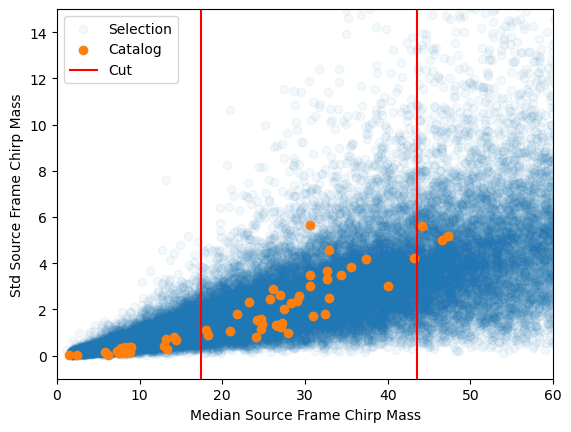

In [12]:
plt.scatter(Mc_sel_med, Mc_sel_sd, alpha=0.05, label='Selection')
plt.scatter(Mc_med, Mc_sd, label='Catalog')
plt.axvline(Mc_cut_min, color='r', label='Cut')
plt.axvline(Mc_cut_max, color='r')
plt.legend()
plt.xlabel('Median Source Frame Chirp Mass')
plt.ylabel('Std Source Frame Chirp Mass');
plt.xlim(0,60)
plt.ylim(-1, 15);

# Compare Injected $M_c$ with Median of Mock PE $M_c$

In [26]:
Mc_sel_true[np.logical_and(Mc_sel_true>Mc_cut_min, Mc_sel_true<Mc_cut_max)].shape

(17834,)

In [27]:
Mc_sel_med[np.logical_and(Mc_sel_med>Mc_cut_min, Mc_sel_med<Mc_cut_max)].shape

(17125,)

# How Many Events are Hop in to the Selected Events Space?

In [28]:
# From the lower end
mask = Mc_sel_true<Mc_cut_min
mask1 = np.logical_and(Mc_sel_med>Mc_cut_min, Mc_sel_med<Mc_cut_max)
mask2 = np.logical_and(mask, mask1)
print('Fraction of events can hop in to selected event space from lower mass part=', len(np.where(mask2==True)[0])/len(Mc_sel_true))

Fraction of events can hop in to selected event space from lower mass part= 0.008864741206748641


In [30]:
# From the upper end
mask3 = Mc_sel_true>Mc_cut_max
mask4 = np.logical_and(Mc_sel_med>Mc_cut_min, Mc_sel_med<Mc_cut_max)
mask5 = np.logical_and(mask3, mask4)
print('Fraction of events can hop in to selected event space from lower mass part=', len(np.where(mask5==True)[0])/len(Mc_sel_true))

Fraction of events can hop in to selected event space from lower mass part= 0.009436659994280812
